In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [2]:
def extract_data(file_path):
    file_description = []
    default_cols = ["STATION", "DATE", "TIME", "LAT", "LON"]
    time_loc_data = 5*["NaN"]
    data_list = []
    with open(file_path) as f:
            indata = False
            for line in f:
                if not indata:
                    if line.startswith("%"):
                        file_description.append(line)
                    elif line.startswith("*"):
                        split_line = line.split()
                        columns = split_line[1:len(split_line)]
                        num_cols = len(columns)
                        indata = True
                else:
                    split_line = line.split()
                    if not line.startswith("S") and not line.startswith("T") and not line.startswith("F") and not line.startswith("P") and len(split_line) == num_cols:
                        data_list.append(time_loc_data + split_line)
                    elif len(split_line) > 0:
                        try:
                            station = split_line[0]
                        except:
                            station = "NaN"
                        try:
                            date = split_line[2] + " " + split_line[3] + " " + split_line[4]
                            date = pd.to_datetime(date, infer_datetime_format=True)
                        except:
                            date = pd.to_datetime("NaN", infer_datetime_format=True, errors = "coerce")
                        try:
                            time = split_line[5]
                        except:
                            time = "NaN"
                        try:
                            lat = split_line[6] + " " + split_line[7]
                            lon = split_line[9] + " " + split_line[10]
                        except:
                            lat, lon = "NaN", "NaN"
                        time_loc_data = [station,date,time,lat,lon]
            
    return(pd.DataFrame(data_list, columns = default_cols + columns))

In [3]:
basedir = "/ocean/shared/SoG/btl/"
chl_dict = dict()

for subdir in os.listdir(basedir):
    if os.path.isdir(basedir + '/' + subdir):
        for file in os.listdir(basedir + '/' + subdir):
            if file.startswith("bottle") and file.endswith(".txt"):
                chl_dict[subdir] = extract_data(basedir + "/" + subdir + "/" + file)
                break
all_chl = pd.concat(chl_dict, join = "inner")

In [4]:
all_chl["DEPTH"] = pd.to_numeric(all_chl["depth"], errors='coerce')
all_chl["chl002"] = pd.to_numeric(all_chl["chl002"], errors='coerce')
all_chl["chl020"] = pd.to_numeric(all_chl["chl020"], errors='coerce')
all_chl["chl200"] = pd.to_numeric(all_chl["chl200"], errors='coerce')

all_chl = all_chl[["STATION", "DATE", "DEPTH","chl002", "chl020", "chl200"]]

In [5]:
df_list = []
for i in range(1,4):
    df = pd.read_excel('/ocean/shared/SoG/PHYTO/Profiles_by_station.xls',i)
    top_index = pd.Index(df["Vol"]).get_loc("Species")
    bottom_index = pd.Index(df["Vol"]).get_loc("Carbon (ng/l)")
    df = pd.concat([df.iloc[:top_index], df.iloc[(bottom_index + 1):]])
    df = df.transpose()
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    df.reset_index(inplace = True)
    df_list.append(df)

In [6]:
all_plank = pd.concat(df_list,  axis=0, ignore_index=True)
all_plank["STATION"] = "S" + all_plank["Site"].astype(str).str.strip()
all_plank["DATE"] = pd.to_datetime(all_plank["Date"], format='%Y-%m-%d', errors = "coerce")
all_plank["DEPTH"] = pd.to_numeric(all_plank["Depth (m)"], errors = "coerce")

all_plank = all_plank[["STATION", "DATE", "DEPTH", "Flagellates", "Mesodinium rubrum", "Total diatoms", "Total flagellates", "Total Ps" ]]

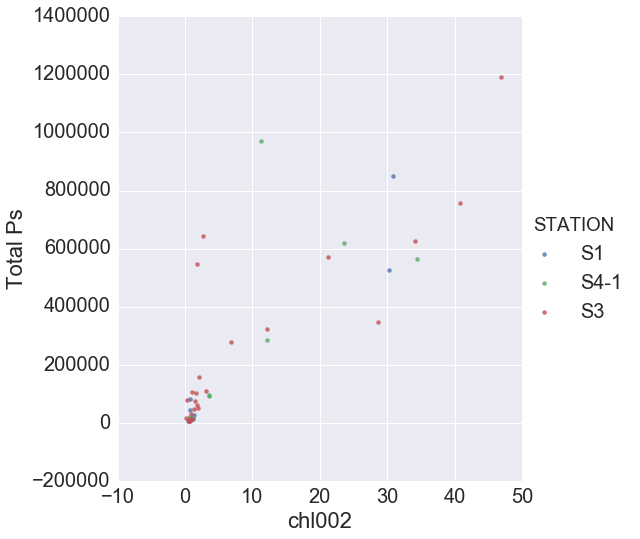

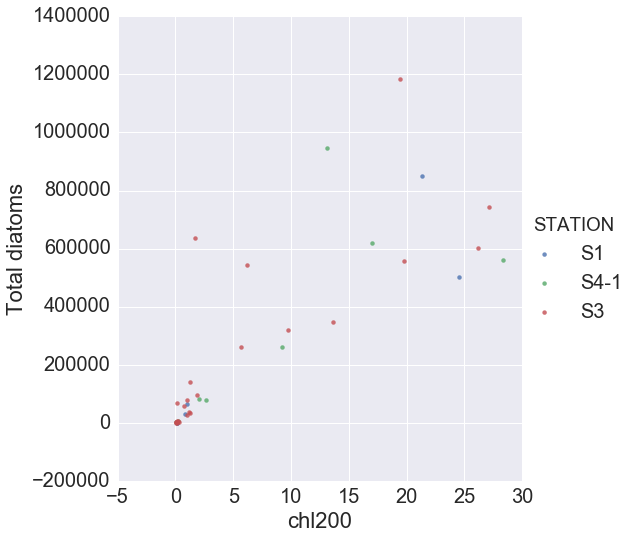

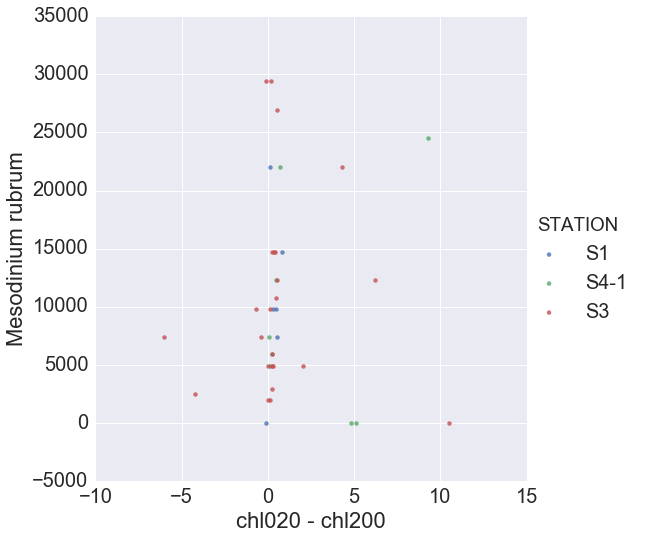

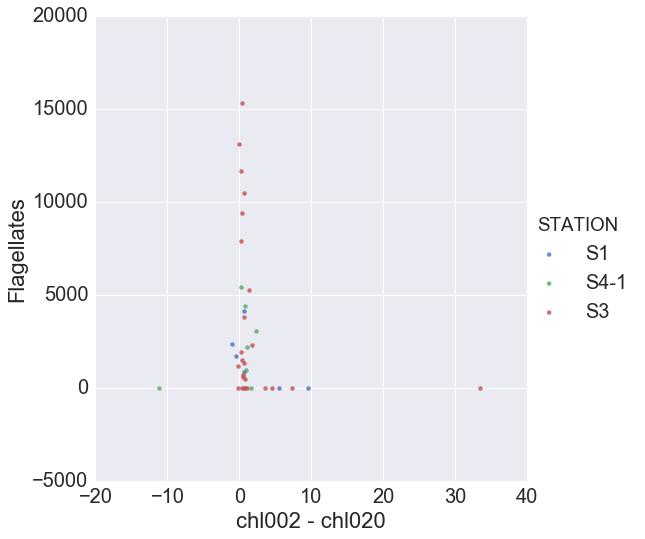

In [7]:
merged = pd.merge(all_plank, all_chl, on = ["DATE", "STATION", "DEPTH"])

merged["chl020 - chl200"] = merged["chl020"] - merged["chl200"]
merged["chl002 - chl020"] = merged["chl002"] - merged["chl020"]

sns.set(font_scale = 2)
plot_size = 8
sns.lmplot(x ="chl002", y ="Total Ps", hue="STATION", data=merged,  fit_reg=False, size = plot_size)
sns.lmplot("chl200" , "Total diatoms", hue="STATION", data=merged,  fit_reg=False, size = plot_size )
sns.lmplot("chl020 - chl200" , "Mesodinium rubrum", hue="STATION", data=merged,  fit_reg=False, size = plot_size )
sns.lmplot("chl002 - chl020" , "Flagellates", hue="STATION", data=merged,  fit_reg=False, size = plot_size )


In [8]:
merged

Vol,STATION,DATE,DEPTH,Flagellates,Mesodinium rubrum,Total diatoms,Total flagellates,Total Ps,chl002,chl020,chl200,chl020 - chl200,chl002 - chl020
0,S1,2003-01-08,5,1254.74,2940.17,100.888,4410.26,7451.31,0.500,NaN,NaN,NaN,NaN
1,S1,2003-03-19,5,1695.6,9800.57,30819.6,4819.74,45440,0.727,1.141,0.871,0.270,-0.414
2,S1,2003-09-10,5,4154.22,7350.43,0,18516,25866.4,1.300,0.600,0.100,0.500,0.700
3,S1,2004-02-11,0,881.712,9800.57,234.841,4149.13,14184.5,1.207,0.564,0.110,0.454,0.643
4,S1,2004-03-02,0,2373.84,14700.9,63939,2373.84,81013.6,0.800,1.835,1.034,0.801,-1.035
5,S1,2004-03-17,0,0,22051.3,503089,2573.07,527713,30.200,24.600,24.500,0.100,5.600
6,S1,2004-03-24,0,0,0,850019,0,850019,30.800,21.200,21.300,-0.100,9.600
7,S4-1,2003-01-08,5,1526.04,15680.9,0,3036.82,18717.7,0.700,NaN,NaN,NaN,NaN
8,S4-1,2003-03-19,5,4408.56,7350.43,76906.1,8026.55,92283,3.489,2.733,2.645,0.088,0.756
9,S4-1,2003-09-10,5,3052.08,22051.3,259668,4823.98,286544,12.200,9.900,9.200,0.700,2.300
